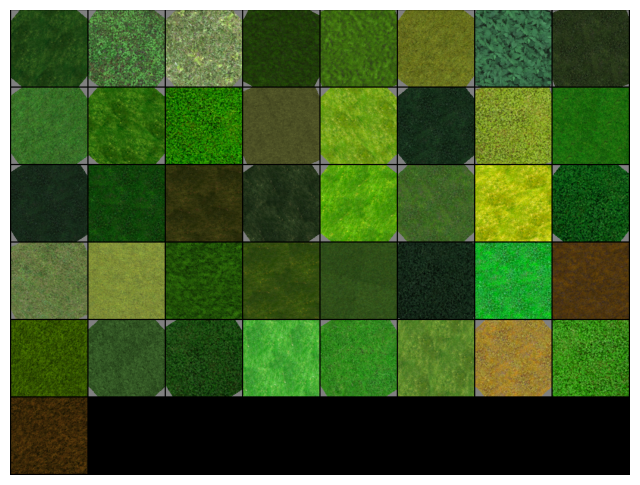

torch.Size([41, 3, 128, 128])


In [36]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import RandomAffine, ColorJitter

# Параметры
image_size = 128  # Размер изображений
batch_size = 64  # Размер батча
data_dir = 'data/grass'  # Папка с изображениями
latent_dim = 100  # Размерность входного шума для генератора
channels = 3  # Цветные изображения (RGB)
device = torch.device('cpu')


def convert_to_rgb(x):
    return x.convert('RGB')

transform = transforms.Compose([
    transforms.Resize((image_size + 30, image_size + 30)),  # Увеличиваем размер холста на 20 пикселей
    transforms.Lambda(convert_to_rgb),  # Преобразуем изображения в RGB
    transforms.RandomHorizontalFlip(p=0.5),  # Случайное горизонтальное отражение
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Случайные цветовые изменения
    transforms.RandomChoice([  # Добавляем случайный выбор поворотов
        transforms.RandomRotation(90, fill=(128, 128, 128)),  # Используем серый фон
        transforms.RandomRotation(180, fill=(128, 128, 128)),
        transforms.RandomRotation(270, fill=(128, 128, 128))
    ]),
    transforms.CenterCrop((image_size, image_size)),  # Обрезаем изображение до исходного размера
    transforms.ToTensor(),  # Преобразуем в тензор
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализуем в диапазон [-1, 1]
])

# Кастомный Dataset для загрузки изображений
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.png') or fname.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# Загрузка данных
dataset = CustomDataset(data_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Функция для обратной нормализации
def denormalize(tensor, mean, std, device):
    # Убедимся, что тензоры mean и std находятся на том же устройстве, что и входной tensor
    mean_tensor = torch.tensor(mean, device=tensor.device).view(3, 1, 1)
    std_tensor = torch.tensor(std, device=tensor.device).view(3, 1, 1)
    denormalized_tensor = tensor * std_tensor + mean_tensor
    return denormalized_tensor.clamp(0, 1)



# Функция для визуализации изображений с обратной нормализацией
def show_images(batch, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    # Обратная нормализация для каждого изображения в батче
    batch = denormalize(batch, mean, std, device)
    
    # Перемещаем на CPU, если изображения на GPU
    batch = batch.cpu()

    # Отображаем изображения в виде сетки
    grid = torchvision.utils.make_grid(batch, nrow=8, padding=2)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).detach().numpy())
    plt.axis('off')
    plt.show()

# Загружаем первую порцию изображений
real_images = next(iter(dataloader))
show_images(real_images)
print(real_images.size())


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

# Параметры
latent_dim = 100  # Размерность входного шума для генератора
channels = 3  # Цветные изображения (RGB)
device = torch.device("cpu")

# Генератор с Residual Blocks для 128x128 на входе, 64x64 на выходе
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)
        
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x)))))) 
        shortcut = self.shortcut(x)
        
        if out.size(2) != shortcut.size(2) or out.size(3) != shortcut.size(3):
            shortcut = F.interpolate(shortcut, size=out.size()[2:], mode='bilinear', align_corners=False)
        
        return out + shortcut
    
class GaussianNoise(nn.Module):
    def __init__(self, stddev=0.1):
        super(GaussianNoise, self).__init__()
        self.stddev = stddev

    def forward(self, x):
        if self.training:  # Шум добавляется только во время тренировки
            noise = torch.randn_like(x) * self.stddev
            return x + noise
        return x

# Генератор с Residual Blocks
class GeneratorWithResiduals(nn.Module):
    def __init__(self, latent_dim, channels):
        super(GeneratorWithResiduals, self).__init__()
        self.noise_layer = GaussianNoise(0.05) 
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),  # Из латентного пространства в 4x4x256
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            ResidualBlock(256, 128),
            ResidualBlock(128, 64),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),  # 64x64x3
            nn.Tanh()  # Tanh, чтобы привести значения пикселей к диапазону [-1, 1]
        )

    def forward(self, input):
        input = self.noise_layer(input)  # Добавляем шум
        return self.main(input)

# Функция потерь с Label Smoothing
def bce_with_label_smoothing(pred, target, eps=0.1):
    target = target * (1 - eps) + 0.5 * eps
    return F.binary_cross_entropy(pred, target)

# Дискриминатор с Feature Matching и Label Smoothing
class DiscriminatorWithSmoothingAndFeatures(nn.Module):
    def __init__(self, channels):
        super(DiscriminatorWithSmoothingAndFeatures, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Dropout для устойчивости
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.features = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, input):
        features = self.features(input)
        output = self.main(input)
        return output, features

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Инициализация моделей
generator = GeneratorWithResiduals(latent_dim, channels).to(device)
discriminator = DiscriminatorWithSmoothingAndFeatures(channels).to(device)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Оптимизаторы
lr = 0.0002
beta1 = 0.5
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Создаем директорию для сохранения изображений
os.makedirs('generated_images', exist_ok=True)


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import sys

# Установим устройство на CPU
device = torch.device("cpu")

# Установите максимальный предел памяти в байтах (например, 8GB = 8 * 1024 * 1024 * 1024)
max_memory_limit = int(7.5 * 1024 * 1024 * 1024)

num_epochs = 200
d_losses, g_losses = [], []

for epoch in range(num_epochs):
    for real_images in dataloader:  
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Генерация меток для реальных и фальшивых изображений
        real_label_tensor = torch.ones(batch_size, 1, 1, 1).to(device) * 0.9  # Label smoothing для реальных
        fake_label_tensor = torch.zeros(batch_size, 1, 1, 1).to(device)  # Метки для фальшивых

        # Генерация фальшивых изображений
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(z)

        # === Обновление дискриминатора ===
        optimizer_d.zero_grad()

        # Выходы дискриминатора
        output_real, _ = discriminator(real_images)
        output_fake, _ = discriminator(fake_images.detach())

        # Ошибки дискриминатора
        real_label_tensor_expanded = real_label_tensor.expand_as(output_real)
        fake_label_tensor_expanded = fake_label_tensor.expand_as(output_fake)
        err_d_real = bce_with_label_smoothing(output_real, real_label_tensor_expanded)
        err_d_fake = bce_with_label_smoothing(output_fake, fake_label_tensor_expanded)

        # Общая ошибка дискриминатора
        err_d = err_d_real + err_d_fake
        err_d.backward()
        optimizer_d.step()

        # === Обновление генератора ===
        optimizer_g.zero_grad()

        output_fake, fake_features = discriminator(fake_images)
        _, real_features = discriminator(real_images)

        # Ошибка генератора (с реальными метками)
        err_g = bce_with_label_smoothing(output_fake, real_label_tensor_expanded)

        # Feature Matching Loss
        feature_matching_loss = F.mse_loss(fake_features.mean(0), real_features.mean(0))
        err_g += 0.1 * feature_matching_loss  # Вес для Feature Matching Loss

        # Оптимизация генератора
        err_g.backward()
        optimizer_g.step()

        # Логирование потерь
        d_losses.append(err_d.item())
        g_losses.append(err_g.item())

    # Сохранение изображений после каждой эпохи
    with torch.no_grad():
        z = torch.randn(64, latent_dim, 1, 1, device=device)
        fake_images = generator(z)

        # Обратная нормализация изображений
        fake_images_denormalized = denormalize(fake_images, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), device=device)

        # Сохранение изображений
        torchvision.utils.save_image(fake_images_denormalized,
                                     f"generated_images/epoch_{epoch + 1}.png", nrow=8)

    # Вывод информации о прогрессе
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss D: {err_d.item():.4f}, Loss G: {err_g.item():.4f}')

# Визуализация потерь
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.legend()
plt.show()

# Сохранение моделей
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


Epoch [1/200], Loss D: 1.5042, Loss G: 0.6005
Epoch [2/200], Loss D: 1.3883, Loss G: 0.5445
Epoch [3/200], Loss D: 1.3218, Loss G: 0.5172
Epoch [4/200], Loss D: 1.1973, Loss G: 0.4874
Epoch [5/200], Loss D: 1.0550, Loss G: 0.4092
Epoch [6/200], Loss D: 0.9607, Loss G: 0.3536
Epoch [7/200], Loss D: 0.8591, Loss G: 0.3014
Epoch [8/200], Loss D: 0.7809, Loss G: 0.2670
Epoch [9/200], Loss D: 0.7348, Loss G: 0.2505
Epoch [10/200], Loss D: 0.6944, Loss G: 0.2293
Epoch [11/200], Loss D: 0.6766, Loss G: 0.2255
Epoch [12/200], Loss D: 0.6630, Loss G: 0.2183
Epoch [13/200], Loss D: 0.6583, Loss G: 0.2147
Epoch [14/200], Loss D: 0.6608, Loss G: 0.2135
Epoch [15/200], Loss D: 0.6562, Loss G: 0.2123
Epoch [16/200], Loss D: 0.6426, Loss G: 0.2105
Epoch [17/200], Loss D: 0.6415, Loss G: 0.2090
Epoch [18/200], Loss D: 0.6389, Loss G: 0.2085
Epoch [19/200], Loss D: 0.6365, Loss G: 0.2083
Epoch [20/200], Loss D: 0.6366, Loss G: 0.2074
Epoch [21/200], Loss D: 0.6343, Loss G: 0.2074
Epoch [22/200], Loss D

KeyboardInterrupt: 

In [ ]:
print(torch.cuda.is_available())  # Должно вернуть True
print(torch.cuda.current_device())  # Проверка активного устройства
print(torch.cuda.memory_allocated())  # Объем выделенной памяти
print(torch.cuda.memory_reserved())  # Общий объем доступной памяти

True
0
0
0
